In [1]:
import pandas as pd
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import seaborn as sns

plt.rcParams['figure.figsize'] = [20, 5]

In [2]:
def handle_missing_values(df, method='drop'):
    if method == 'drop':
        return df.dropna()
    elif method == 'mean':
        return df.fillna(df.mean())
    else:
        raise ValueError("Method must be either 'drop' or 'mean'.")

def create_lagged_features(df, target, lags=1):
    lagged_data = []
    for col in df.columns:
        if col != 'sasdate':
            for i in range(1, lags + 1):
                lagged_data.append(df[col].shift(i).rename(f"{col}_lag{i}"))
    lagged_df = pd.concat([df] + lagged_data, axis=1)
    lagged_df.dropna(inplace=True)
    return lagged_df

def normalize_features(df):
    df_numeric = df.select_dtypes(include=[np.number])
    return (df_numeric - df_numeric.min()) / (df_numeric.max() - df_numeric.min())

def train_test_split(df, target, test_size=0.2):
    n = len(df)
    test_split_idx = int(n * (1 - test_size))
    drop_columns = [target]
    if 'sasdate' in df.columns:
        drop_columns.append('sasdate')
    X = df.drop(drop_columns, axis=1)
    y = df[target]
    X_train, X_test = X.iloc[:test_split_idx], X.iloc[test_split_idx:]
    y_train, y_test = y.iloc[:test_split_idx], y.iloc[test_split_idx:]
    return X_train, X_test, y_train, y_test

def log_differencing(df, columns=None):
    df_log_diff = df.copy()
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns

    for col in columns:
        series = df[col].values

        log_series = np.empty_like(series, dtype=series.dtype)

        # Handle NaNs if present in the original series
        nan_mask = np.isnan(series)

        # Apply log only to positive values, keep zero, negative and NaN values unchanged
        mask = series > 0
        log_series[mask] = np.log(series[mask])
        log_series[~mask] = series[~mask]
        log_series[nan_mask] = np.nan  # Assign NaNs back where they were

        # Perform differencing
        log_diff = log_series - np.roll(log_series, shift=1)
        df_log_diff[col] = log_diff

    df_log_diff.dropna(inplace=True)
    return df_log_diff

In [3]:
def linear(Z):
    return Z

def initialize_parameters(layer_sizes, use_batchnorm):
    np.random.seed(42)
    parameters = {}
    adam_params = {'m': {}, 'v': {}}  # Initialize Adam parameters
    L = len(layer_sizes)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_sizes[l], layer_sizes[l - 1]) * np.sqrt(1. / layer_sizes[l - 1])
        parameters['b' + str(l)] = np.zeros((layer_sizes[l], 1))

        # Initialize Adam parameters for W and b
        adam_params['m']['W' + str(l)] = np.zeros((layer_sizes[l], layer_sizes[l - 1]))
        adam_params['m']['b' + str(l)] = np.zeros((layer_sizes[l], 1))
        adam_params['v']['W' + str(l)] = np.zeros((layer_sizes[l], layer_sizes[l - 1]))
        adam_params['v']['b' + str(l)] = np.zeros((layer_sizes[l], 1))

        if use_batchnorm.get(l, False):
            parameters['gamma' + str(l)] = np.ones((layer_sizes[l], 1))
            parameters['beta' + str(l)] = np.zeros((layer_sizes[l], 1))

            # Initialize Adam parameters for gamma and beta if Batch Normalization is used
            adam_params['m']['gamma' + str(l)] = np.zeros((layer_sizes[l], 1))
            adam_params['m']['beta' + str(l)] = np.zeros((layer_sizes[l], 1))
            adam_params['v']['gamma' + str(l)] = np.zeros((layer_sizes[l], 1))
            adam_params['v']['beta' + str(l)] = np.zeros((layer_sizes[l], 1))

    return parameters, adam_params

# Global variables for moving averages
moving_means = {}
moving_vars = {}

def forward_propagation(X, parameters, use_batchnorm, use_dropout, keep_prob, is_training=True):
    global moving_means, moving_vars

    caches = {}
    dropout_masks = {}  # To store dropout masks
    A = X
    L = len([key for key in parameters.keys() if "W" in key])

    for l in range(1, L + 1):
        A_prev = A
        Z = np.dot(parameters['W' + str(l)], A_prev) + parameters['b' + str(l)]

        if use_batchnorm.get(l, False):
            if is_training:
                mean = np.mean(Z, axis=1, keepdims=True)
                var = np.var(Z, axis=1, keepdims=True)

                moving_means[str(l)] = 0.9 * moving_means.get(str(l), mean) + 0.1 * mean
                moving_vars[str(l)] = 0.9 * moving_vars.get(str(l), var) + 0.1 * var
            else:
                mean = moving_means.get(str(l), np.zeros((Z.shape[0], 1)))
                var = moving_vars.get(str(l), np.ones((Z.shape[0], 1)))

            Z_norm = (Z - mean) / np.sqrt(var + 1e-8)
            Z = parameters['gamma' + str(l)] * Z_norm + parameters['beta' + str(l)]
            caches['Z_norm' + str(l)] = Z_norm
            caches['mean' + str(l)] = mean
            caches['var' + str(l)] = var

        if l == L:
            A = linear(Z)  # Replace this with your own activation function for the last layer
        else:
            A = np.maximum(0, Z)  # ReLU activation

        if use_dropout.get(l, False) and is_training:  # Apply dropout only during training
            dropout_mask = np.random.rand(A.shape[0], A.shape[1]) < keep_prob
            A *= dropout_mask
            A /= keep_prob
            dropout_masks[l] = dropout_mask  # Save the mask for backpropagation

        caches['A' + str(l)] = A
        caches['Z' + str(l)] = Z

    return A, caches, dropout_masks  # Added dropout_masks to the return


def compute_cost(Y_pred, Y_true, parameters, lambd):
    m = Y_true.shape[1]
    cost = (1/(2*m)) * np.sum((Y_true - Y_pred)**2)

    L = len([key for key in parameters.keys() if "W" in key])
    regularization_term = 0
    for l in range(1, L + 1):
        regularization_term += (lambd / (2*m)) * np.sum(np.square(parameters['W' + str(l)]))

    cost += regularization_term
    return cost


def backward_propagation(X, Y, Y_pred, caches, parameters, dropout_masks, keep_prob, lambd, use_batchnorm):
    grads = {}
    L = len([key for key in parameters.keys() if "W" in key])
    m = X.shape[1]
    Y = Y.reshape(Y_pred.shape)
    dZ = Y_pred - Y

    for l in reversed(range(1, L + 1)):
        A_prev = caches["A" + str(l - 1)] if l != 1 else X

        if use_batchnorm.get(l, False):
            Z_norm = caches['Z_norm' + str(l)]
            mean = caches['mean' + str(l)]
            var = caches['var' + str(l)]

            gamma = parameters['gamma' + str(l)]

            dgamma = np.sum(dZ * Z_norm, axis=1, keepdims=True)
            dbeta = np.sum(dZ, axis=1, keepdims=True)

            grads["dgamma" + str(l)] = dgamma
            grads["dbeta" + str(l)] = dbeta

            dZ_norm = gamma * dZ
            dvar = np.sum(dZ_norm * (Z_norm - mean) * -0.5 * np.power(var + 1e-8, -1.5), axis=1, keepdims=True)
            dmean = np.sum(dZ_norm * -1 / np.sqrt(var + 1e-8), axis=1, keepdims=True) + dvar * np.sum(-2 * (Z_norm - mean), axis=1, keepdims=True) / m
            dZ = dZ_norm / np.sqrt(var + 1e-8) + dvar * 2 * (Z_norm - mean) / m + dmean / m

        grads["dW" + str(l)] = (1/m) * np.dot(dZ, A_prev.T) + (lambd / m) * parameters['W' + str(l)]
        grads["db" + str(l)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)

        if l > 1:
            dZ = np.dot(parameters["W" + str(l)].T, dZ) * (A_prev > 0)

            # Apply dropout if enabled for this layer
            if dropout_masks.get(l - 1, None) is not None:
                dZ *= dropout_masks[l - 1]
                dZ /= keep_prob

    return grads


def update_parameters(parameters, grads, learning_rate, use_batchnorm, adam_params, t, beta1=0.9, beta2=0.999, epsilon=1e-8):
    L = len([key for key in parameters.keys() if "W" in key])

    # Adam update for each parameter
    for l in range(1, L + 1):
        for param in ['W', 'b']:
            # Compute first and second moment for Adam
            adam_params['m'][param + str(l)] = beta1 * adam_params['m'][param + str(l)] + (1 - beta1) * grads['d' + param + str(l)]
            adam_params['v'][param + str(l)] = beta2 * adam_params['v'][param + str(l)] + (1 - beta2) * np.square(grads['d' + param + str(l)])

            # Bias correction for first and second moment
            m_corrected = adam_params['m'][param + str(l)] / (1 - np.power(beta1, t))
            v_corrected = adam_params['v'][param + str(l)] / (1 - np.power(beta2, t))

            # Update parameter
            parameters[param + str(l)] -= learning_rate * m_corrected / (np.sqrt(v_corrected) + epsilon)

        if use_batchnorm.get(l, False):
            for param in ['gamma', 'beta']:
                # Compute first and second moment for Adam
                adam_params['m'][param + str(l)] = beta1 * adam_params['m'][param + str(l)] + (1 - beta1) * grads['d' + param + str(l)]
                adam_params['v'][param + str(l)] = beta2 * adam_params['v'][param + str(l)] + (1 - beta2) * np.square(grads['d' + param + str(l)])

                # Bias correction for first and second moment
                m_corrected = adam_params['m'][param + str(l)] / (1 - np.power(beta1, t))
                v_corrected = adam_params['v'][param + str(l)] / (1 - np.power(beta2, t))

                # Update parameter
                parameters[param + str(l)] -= learning_rate * m_corrected / (np.sqrt(v_corrected) + epsilon)

    return parameters, adam_params


def random_mini_batches(X, Y, mini_batch_size=64, seed=42):
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []

    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]

    # Step 2: Partition (shuffled_X, shuffled_Y)
    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size: (k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size: (k + 1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches


def train_neural_network(X, Y, layer_sizes, num_epochs, learning_rate, mini_batch_size, use_batchnorm, use_dropout, keep_prob, lambd=0.0, beta1=0.9, beta2=0.999, epsilon=1e-8):
    parameters, adam_params = initialize_parameters(layer_sizes, use_batchnorm)
    seed = 10  # For shuffling mini-batches

    for i in range(num_epochs):
        seed += 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)  # Assuming you have a function to create minibatches
        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation with dropout
            Y_pred, caches, dropout_masks = forward_propagation(minibatch_X, parameters, use_batchnorm, use_dropout, keep_prob, is_training=True)

            # Compute cost
            cost = compute_cost(Y_pred, minibatch_Y, parameters, lambd)

            # Backward propagation with dropout
            grads = backward_propagation(minibatch_X, minibatch_Y, Y_pred, caches, parameters, dropout_masks, keep_prob, lambd, use_batchnorm)

            # Update parameters using Adam
            parameters, adam_params = update_parameters(parameters, grads, learning_rate, use_batchnorm, adam_params, t=i+1, beta1=beta1, beta2=beta2, epsilon=epsilon)

        if i % 100 == 0 or i == num_epochs - 1:
            progress = int((i / num_epochs) * 100)
            bar_length = 50
            block = int(round(bar_length * progress / 100))
            progress_bar = "[" + "=" * block + ">" + "." * (bar_length - block - 1) + "]"
            print(f"\r Epoch {i + 1} Progress: {progress_bar} Cost: {cost}", end='')
    print()
    return parameters


def predict(X, parameters, use_batchnorm):
    Y_pred, _, _ = forward_propagation(X, parameters, use_batchnorm, {}, 1.0, is_training=False)
    return Y_pred

def calculate_rmse(predictions, actuals):
    return math.sqrt(((predictions - actuals) ** 2).mean())



In [4]:
def network_summary(layer_sizes, use_batchnorm, use_dropout):
    total_params = 0
    print("Layer (type)        Output Shape       Param #")
    print("===============================================")
    print(f"Input Layer        (None, {layer_sizes[0]})        0")
    for l in range(1, len(layer_sizes)):
        W_shape = (layer_sizes[l], layer_sizes[l-1])
        b_shape = (layer_sizes[l], 1)
        current_params = np.prod(W_shape) + np.prod(b_shape)

        # Include gamma and beta parameters if Batch Normalization is used
        if use_batchnorm.get(l, False):
            gamma_shape = (layer_sizes[l], 1)
            beta_shape = (layer_sizes[l], 1)
            current_params += np.prod(gamma_shape) + np.prod(beta_shape)

        total_params += current_params
        print(f"Dense Layer {l}     (None, {layer_sizes[l]})        {current_params}")
        print(f"    W{l}            {W_shape}")
        print(f"    b{l}            {b_shape}")

        if use_batchnorm.get(l, False):
            print(f"    Batch Norm      Yes")
            print(f"        gamma{l}     {gamma_shape}")
            print(f"        beta{l}      {beta_shape}")

        if use_dropout.get(l, False):
            print(f"    Dropout         Yes")

        print("-----------------------------------------------")
    print(f"Total params: {total_params}")
    print(f"Trainable params: {total_params}")
    print(f"Non-trainable params: 0")
    print()
    print()


def generate_timeline(initial_window, full_length, horizon):
    print("Timeline Graphic Legend: \n\u25A0 Training \n\u25A1 Testing \n\u25AA Future")
    timeline_blocks = []
    for i in range(initial_window, full_length - horizon + 1):
        train_blocks = ['\u25A0' for _ in range(i)]
        test_blocks = ['\u25A1' for _ in range(horizon)]
        future_blocks = ['\u25AA' for _ in range(full_length - i - horizon)]

        timeline = train_blocks + test_blocks + future_blocks
        timeline_blocks.append("".join(timeline))

    for block in timeline_blocks:
        print(block)


### Initial Window Size

The term "initial window" refers to the first $ N $ data points in the training set used to train the model. If you set the initial window size to $ N $, it means that the neural network will initially be trained on these first $ N $ data points.

#### Dimensions of the Initial Input Matrix

For an initial window of size $ N $, the dimensions of the input matrix $ X $ will be:

$$
\text{Dimensions of } X_{\text{initial}} = (\text{Number of Features}) \times N
$$

### Expanding Window

The expanding window approach is used to simulate a realistic time series forecasting scenario. After the model is trained on the initial window, it is retrained on a window that includes the initial $ N $ data points and the next $ H $ data points, where $ H $ is the "horizon" parameter.

#### Dimensions of the Expanding Input Matrix

For the next expanding window, the dimensions of the input matrix $ X $ will be:

$$
\text{Dimensions of } X_{\text{next}} = (\text{Number of Features}) \times (N + H)
$$

Here, $ H $ is the number of future data points you are predicting. The horizon.

### Example

Let's say we have:

- Number of Features: 246
- Initial Window Size: 50
- Horizon: 5

The dimensions of $ X $ for different scenarios would be:

- **Initial Window**: $ 246 \times 50 $
- **First Expanded Window**: $ 246 \times 55 $ (50 initial + 5 from the horizon)
- **Second Expanded Window**: $ 246 \times 60 $ (55 from the first expanded window + 5 from the horizon)

And so on. This way, the model is retrained on an increasingly larger set of data, incorporating more and more of the time series history as the window expands.


In [5]:
def expanding_window_validation(X, y, initial_window, horizon, layer_sizes, num_epochs, learning_rate, mini_batch_size, use_batchnorm, use_dropout, keep_prob, date_column, lambd=0.0):
    predictions = []
    actuals = []
    saved_models = []  # List to save trained models
    num_windows = len(X) - initial_window - horizon + 1

    # Generate Unicode colored blocks to visualize the training and testing windows
    full_length = len(X)

    generate_timeline(initial_window, full_length, horizon)  # Generate the timeline graphic

    print()
    print()
    for i in range(initial_window, len(X) - horizon + 1):
        print(f"Window {i - initial_window + 1} of {num_windows}")
        print(f"Training Window Size: {i}, Test Window Size: {horizon}")

        train_X, test_X = X.iloc[:i], X.iloc[i:i+horizon]
        train_y, test_y = y.iloc[:i], y.iloc[i:i+horizon]

        train_start_date, train_end_date = date_column.iloc[0], date_column.iloc[i - 1]
        test_start_date, test_end_date = date_column.iloc[i], date_column.iloc[i + horizon - 1]

        train_start_date = train_start_date.strftime("%Y-%m-%d")
        train_end_date = train_end_date.strftime("%Y-%m-%d")
        test_start_date = test_start_date.strftime("%Y-%m-%d")
        test_end_date = test_end_date.strftime("%Y-%m-%d")

        print(f"Train Period: {train_start_date} to {train_end_date}")
        print(f"Test Period: {test_start_date} to {test_end_date}")

        train_X_nn = train_X.T.values
        train_y_nn = train_y.values.reshape(1, -1)

        parameters = train_neural_network(train_X_nn, train_y_nn, layer_sizes, num_epochs, learning_rate, mini_batch_size, use_batchnorm, use_dropout, keep_prob, lambd)
        saved_models.append(parameters)  # Save the trained model

        test_X_nn = test_X.T.values
        prediction = predict(test_X_nn, parameters, use_batchnorm)

        rmse = math.sqrt(np.mean((test_y.values - prediction[0]) ** 2))
        print(f"RMSE for this window: {rmse}\n")

        predictions.append(prediction[0][0])
        actuals.append(test_y.values[0])

    return predictions, actuals, saved_models

## Mini-Batch Gradient Descent within Expanding Windows

### Step 1: Shuffle and Partition Data into Mini-Batches

- The training data $ X $ within the current window is of dimension $ (m, n) $, where $ m $ is the number of features and $ n $ is the number of data points.
- This data is shuffled and partitioned into $ k $ mini-batches $ X_1, X_2, \ldots, X_k $ each of size $ m \times \left\lfloor \frac{n}{k} \right\rfloor $.

### Step 2: Forward Propagation

- For each mini-batch $ X_i $, forward propagation is applied to predict the output $ \hat{Y}_i $:

  $$
  \hat{Y}_i = \text{ForwardPropagation}(X_i, W, b)
  $$

  Here $ W $ and $ b $ are the weights and biases of the network, and the function ForwardPropagation computes the output layer by layer.

### Step 3: Compute cost

- The cost$ J $ is computed using the Mean Squared Error (MSE) formula:

  $$
  J = \frac{1}{2 \times \text{size of mini-batch}} \sum_{i=1}^{\text{size of mini-batch}} (\hat{Y}_i - Y_i)^2
  $$

### Step 4: Backward Propagation

- Gradients $ \frac{\partial J}{\partial W} $ and $ \frac{\partial J}{\partial b} $ are computed for the cost with respect to each parameter.

  $$
  \frac{\partial J}{\partial W} = \text{BackwardPropagation}(\frac{\partial J}{\partial \hat{Y}}, W, b)
  $$

### Step 5: Update Parameters

- The weights $ W $ and biases $ b $ are updated using the gradients:

  $$
  W = W - \alpha \times \frac{\partial J}{\partial W}
  $$
  $$
  b = b - \alpha \times \frac{\partial J}{\partial b}
  $$

  Here $ \alpha $ is the learning rate, which controls the step size in the parameter space during updates.

### Step 6: Next Mini-Batch

- Once the parameters are updated using the first mini-batch, the next mini-batch $ X_{i+1} $ is used.
- Steps 2-5 are repeated for this new mini-batch.

### Step 7: Complete One Epoch

- An "epoch" is one complete forward and backward pass of all the mini-batches.
- This means repeating Steps 2-6 for each mini-batch $ X_1, X_2, \ldots, X_k $.

### Step 8: Multiple Epochs

- The entire process (Steps 1-7) is repeated for a number of times specified by `num_epochs`.


In [6]:
df = pd.read_csv('current.csv').iloc[2:]
df['sasdate'] = pd.to_datetime(df['sasdate'], errors='coerce')
df_clean = handle_missing_values(df, method='drop')
#df_log_diff = log_differencing(df_clean)

# The window size is the number of consecutive data points and the horizion is how many data points in the future we are predicting
target = 'S&P 500'
lags = 3
initial_window = 50  # The initial window size for expanding-window validation
horizon = 5  # The prediction horizon

df_lagged = create_lagged_features(df_clean, target=target, lags=lags)
df_normalized = normalize_features(df_lagged)

# Perform the train-test split
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(df_normalized, target=target, test_size=test_size)

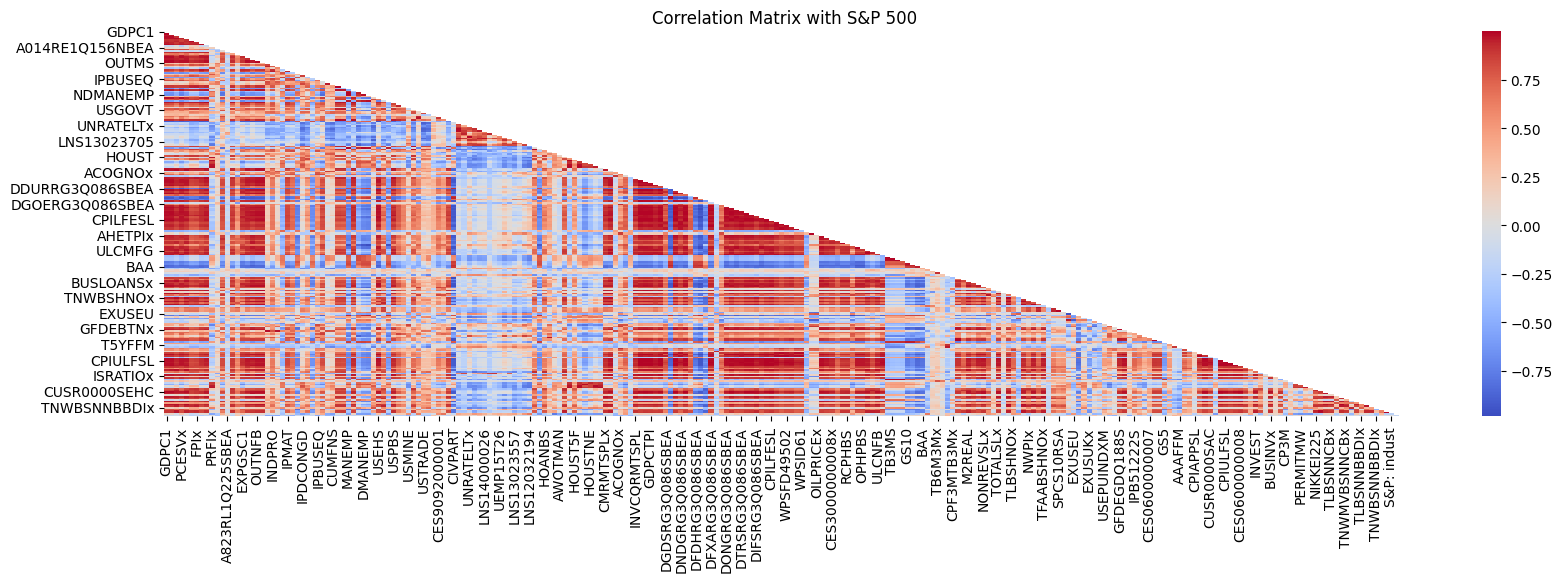

In [7]:
corr_matrix = df_clean.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title(f'Correlation Matrix with {target}')
plt.show()

In [ ]:
# Extract the 'sasdate' column as the time axis
time_axis = df_clean['sasdate']
feature_columns = [col for col in df_clean.columns if col != 'sasdate']
for feature in feature_columns:
    plt.plot(time_axis, df_clean[feature])
    plt.xlabel('Time')
    plt.ylabel(f'{feature} Value')
    plt.title(f'Time Series of {feature}')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [10]:
layer_sizes = [X_train.shape[1], 64, 32, 1]
num_epochs = 1000
mini_batch_size = 64
learning_rate = 0.001
lambd = 0.01

# New hyperparameters for dropout
use_dropout = {1: False, 2: False}  # Enable dropout only for layer 1
keep_prob = 0.8  # Keep probability for dropout

# Specify which layers should use Batch Normalization
use_batchnorm = {1: True, 2: True}

# Display a summary of the network architecture
network_summary(layer_sizes, use_batchnorm, use_dropout)

# Reshape the data to fit the neural network input and output shape
X_train_nn = X_train.T.values
y_train_nn = y_train.values.reshape(1, -1)

# Name of the date column
date_column_name = 'sasdate'

# Expanding window validation
predictions_expanding, actuals_expanding, saved_models = expanding_window_validation(
    X_train, y_train, initial_window=initial_window, horizon=horizon,
    layer_sizes=layer_sizes, num_epochs=num_epochs,
    learning_rate=learning_rate, mini_batch_size=mini_batch_size,
    use_batchnorm=use_batchnorm, use_dropout=use_dropout, keep_prob=keep_prob,  # Added these
    date_column=df_clean[date_column_name], lambd=lambd
)

Layer (type)        Output Shape       Param #
Input Layer        (None, 983)        0
Dense Layer 1     (None, 64)        63104
    W1            (64, 983)
    b1            (64, 1)
    Batch Norm      Yes
        gamma1     (64, 1)
        beta1      (64, 1)
-----------------------------------------------
Dense Layer 2     (None, 32)        2144
    W2            (32, 64)
    b2            (32, 1)
    Batch Norm      Yes
        gamma2     (32, 1)
        beta2      (32, 1)
-----------------------------------------------
Dense Layer 3     (None, 1)        33
    W3            (1, 32)
    b3            (1, 1)
-----------------------------------------------
Total params: 65281
Trainable params: 65281
Non-trainable params: 0


Timeline Graphic Legend: 
■ Training 
□ Testing 
▪ Future
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□▪▪▪

In [12]:
# Using the last trained model to make predictions on the test set
last_model = saved_models[-1]

# Reshape the test data to fit the neural network input and output shape
X_test_nn = X_test.T.values
y_test_nn = y_test.values.reshape(1, -1)

# Make predictions on the test set
predictions_test = predict(X_test_nn, last_model, use_batchnorm)

# Reshape the predictions to match the original data shape
predictions_test_reshaped = predictions_test[0]

# Calculate RMSE on the test set
rmse_test = calculate_rmse(predictions_test_reshaped, y_test.values)

print("Test Predictions:", predictions_test_reshaped)
print("Test RMSE:", rmse_test)

Test Predictions: [0.46370651 0.47628672 0.4914641  0.50983    0.49490338 0.49664725
 0.33473981 0.34225089 0.32763851 0.41783578 0.46314271 0.4971728
 0.50997267 0.52403783 0.5434868  0.56193886 0.5773169  0.62393003]
Test RMSE: 0.29744832408251815


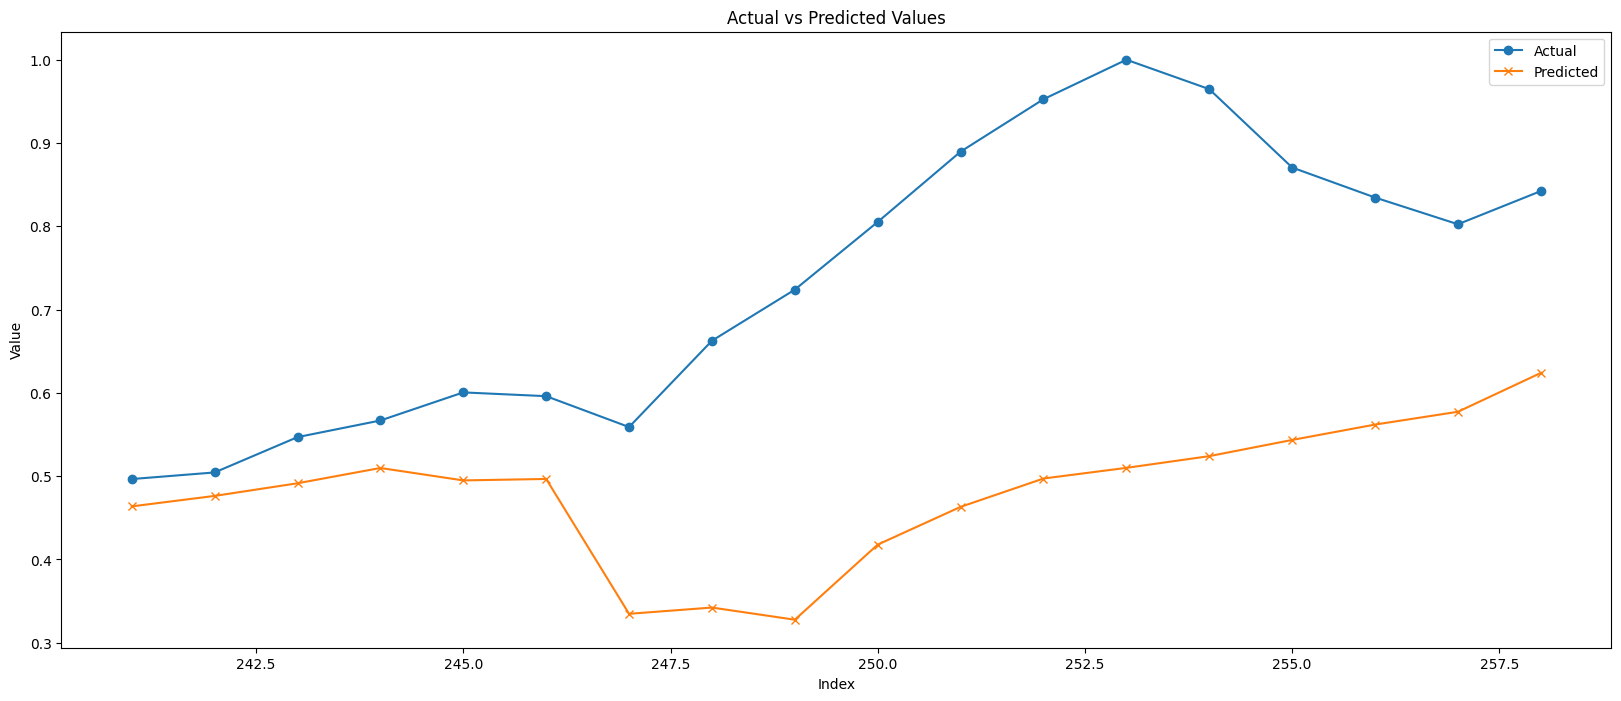

In [13]:
import matplotlib.pyplot as plt

# Plot the actual and predicted values
plt.figure(figsize=(20, 8))
plt.plot(y_test.index, y_test.values, label='Actual', marker='o')
plt.plot(y_test.index, predictions_test_reshaped, label='Predicted', marker='x')

plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

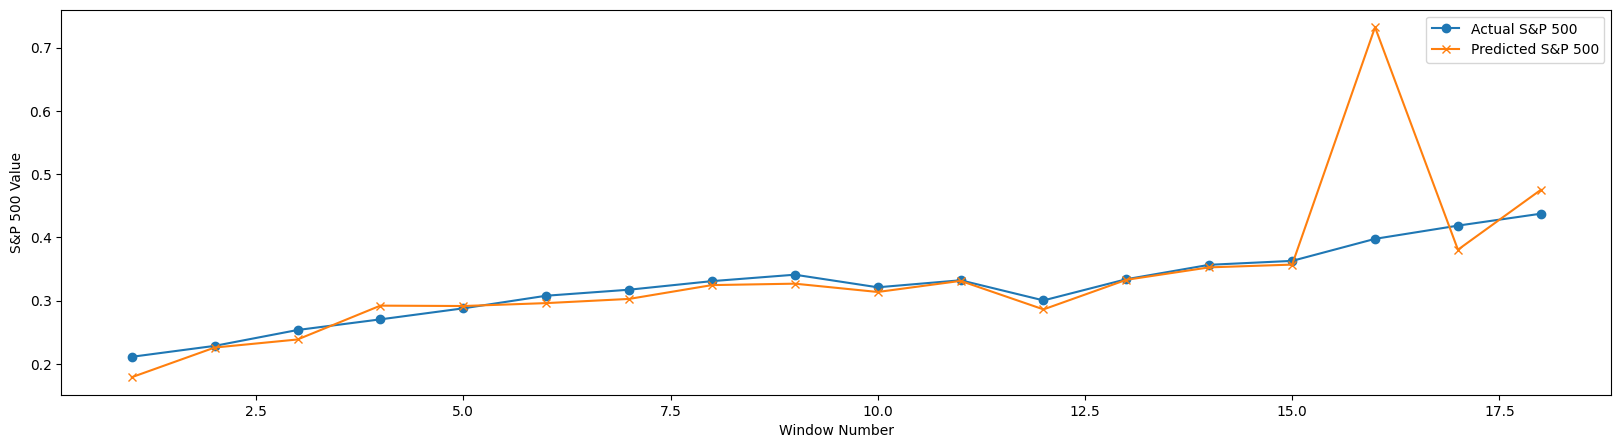

In [ ]:
window_numbers = list(range(1, len(predictions_expanding) + 1))
plt.plot(window_numbers, actuals_expanding, label=f"Actual {target}", marker='o')
plt.plot(window_numbers, predictions_expanding, label=f"Predicted {target}", marker='x')
plt.xlabel("Window Number")
plt.ylabel(f"{target} Value")
plt.legend()
plt.show()

In [ ]:
# Convert them back to the original shape
X_train_nn = X_train_nn.T
y_train_nn = y_train_nn.T
X_val = X_test.T.values
y_val = y_test.values

# Assume df_lagged is your DataFrame with lagged features
original_feature_names = df_lagged.drop([target, 'sasdate'], axis=1).columns.tolist()

# Initialize a dictionary to hold the top features for each model
top_features_over_time = {}

# Loop through each saved model
for idx, model in enumerate(saved_models):
    print(f"Calculating feature importances for model {idx + 1}...")

    # Initialize feature importances dictionary
    feature_importances = {}

    # Calculate baseline RMSE
    y_pred_baseline = predict(X_val, model, use_batchnorm)
    baseline_rmse = calculate_rmse(y_pred_baseline, y_val)

    # Loop over each feature
    for i in range(X_val.shape[0]):
        # Make a copy of the validation data
        X_val_permuted = X_val.copy()

        # Shuffle the values of the feature
        np.random.shuffle(X_val_permuted[i, :])

        # Make predictions using the model and the permuted data
        y_pred_permuted = predict(X_val_permuted, model, use_batchnorm)

        # Calculate RMSE for the permuted data
        permuted_rmse = calculate_rmse(y_pred_permuted, y_val)

        # Calculate the importance of the feature as the difference between the permuted and baseline RMSE
        feature_importances[original_feature_names[i]] = np.abs(permuted_rmse - baseline_rmse)

    # Sort the feature importances in descending order
    sorted_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)}

    # Select the top 20 features
    top_20_features = dict(list(sorted_importances.items())[:20])

    # Save the top features for this model
    top_features_over_time[f"Model_{idx + 1}"] = top_20_features

Calculating feature importances for model 1...
Calculating feature importances for model 2...
Calculating feature importances for model 3...
Calculating feature importances for model 4...
Calculating feature importances for model 5...
Calculating feature importances for model 6...
Calculating feature importances for model 7...
Calculating feature importances for model 8...
Calculating feature importances for model 9...
Calculating feature importances for model 10...
Calculating feature importances for model 11...
Calculating feature importances for model 12...
Calculating feature importances for model 13...
Calculating feature importances for model 14...
Calculating feature importances for model 15...
Calculating feature importances for model 16...
Calculating feature importances for model 17...
Calculating feature importances for model 18...


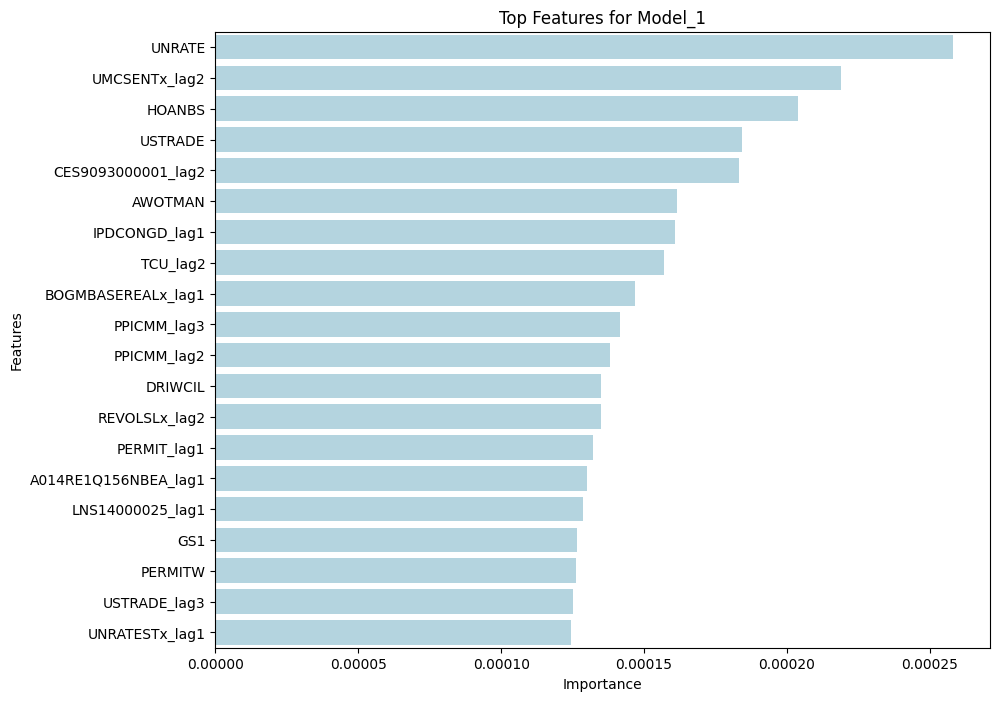

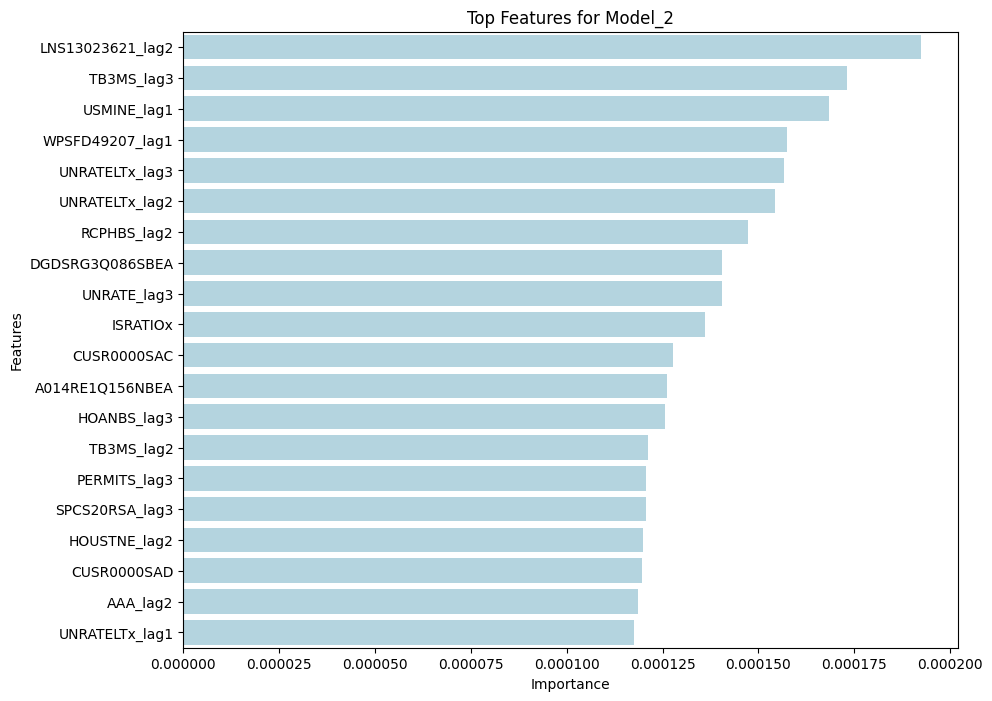

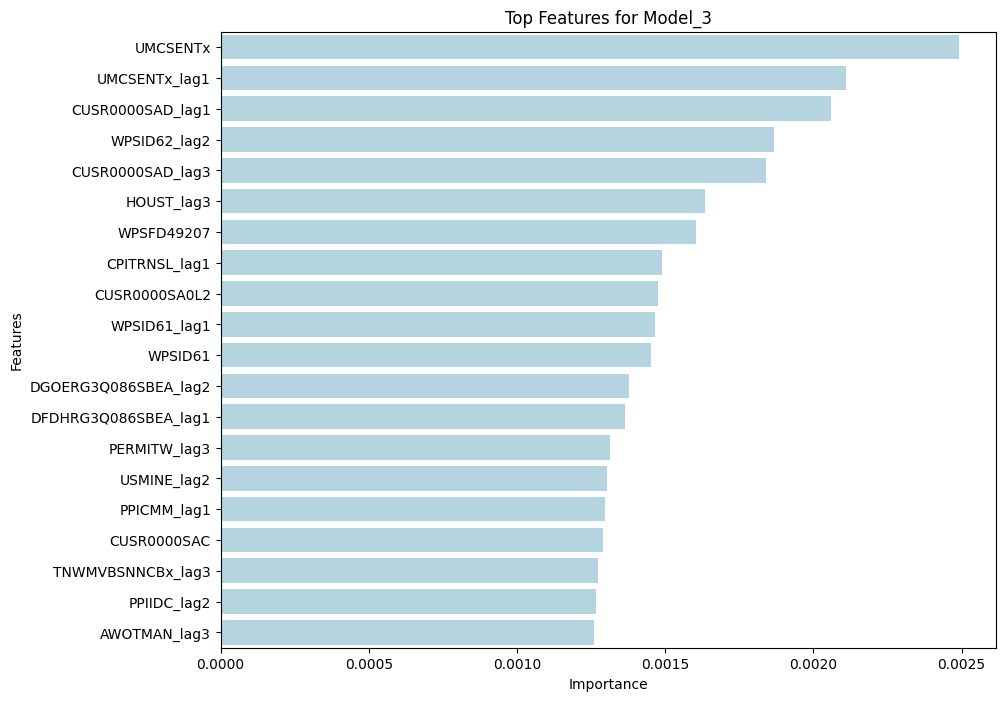

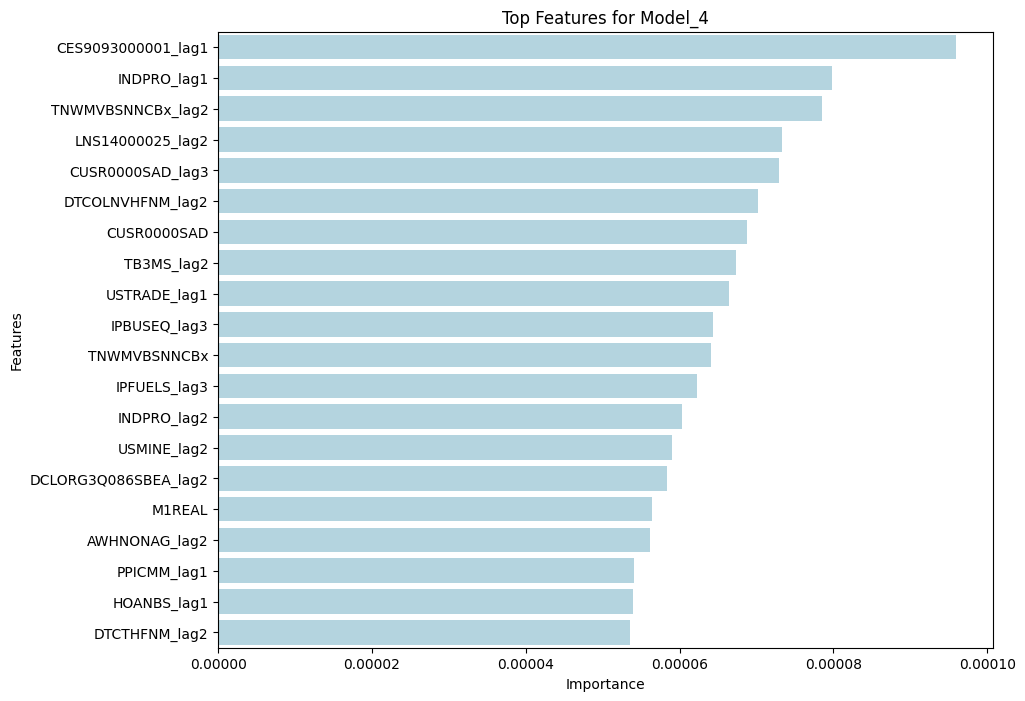

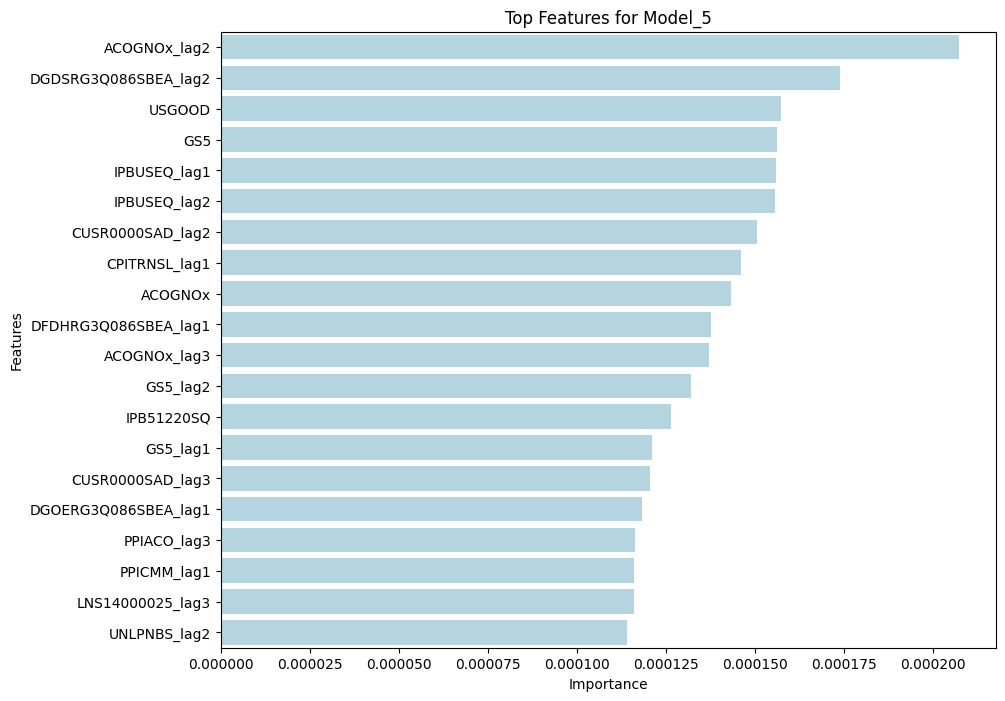

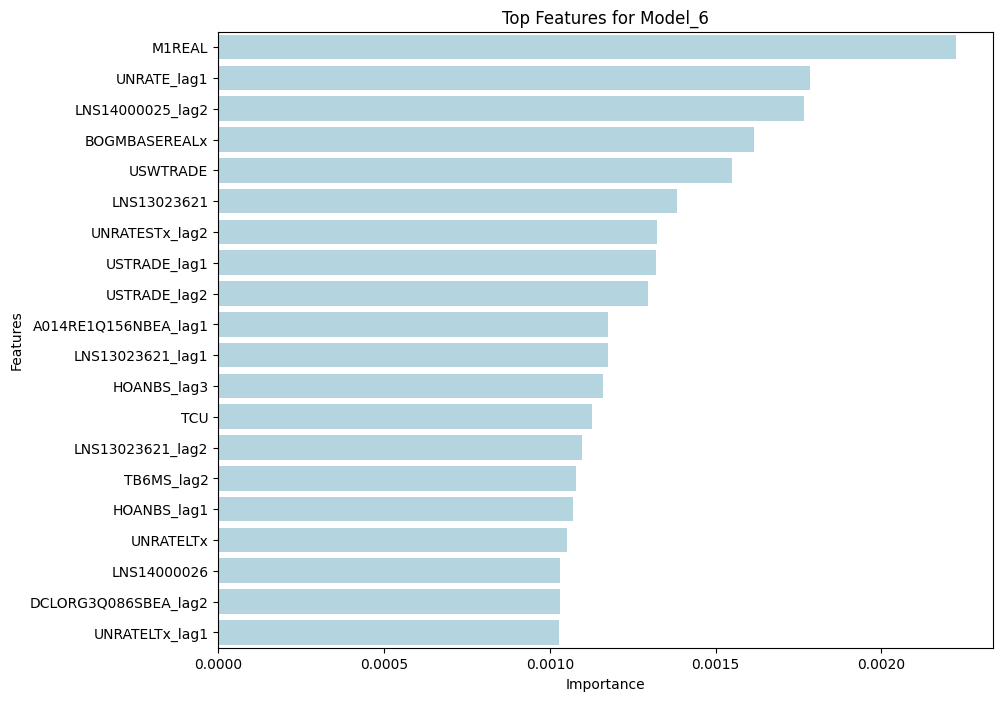

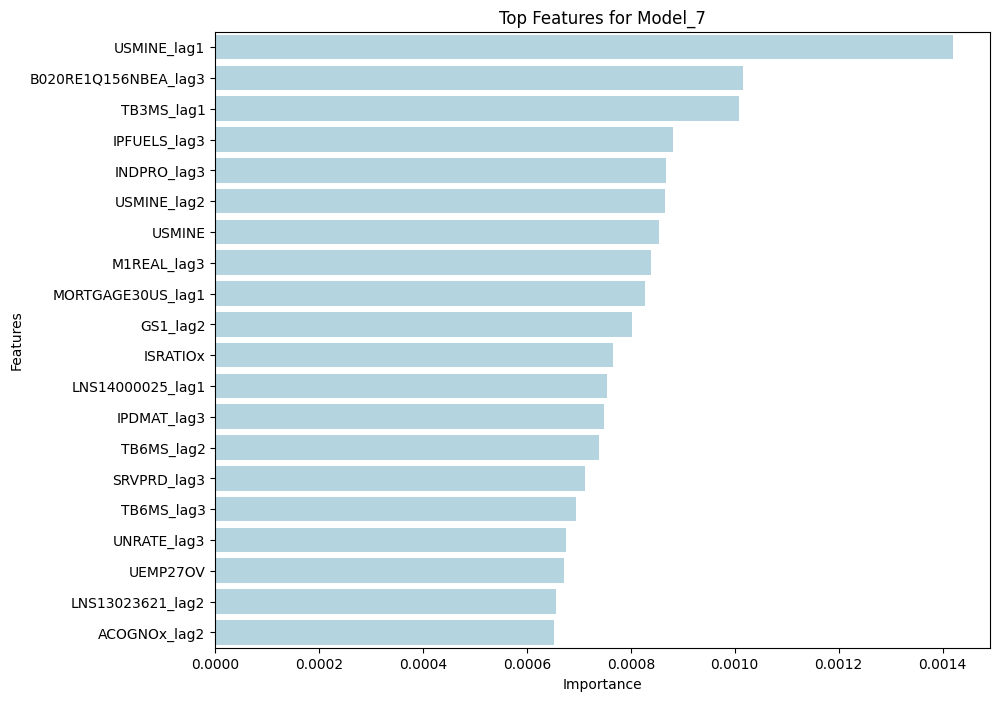

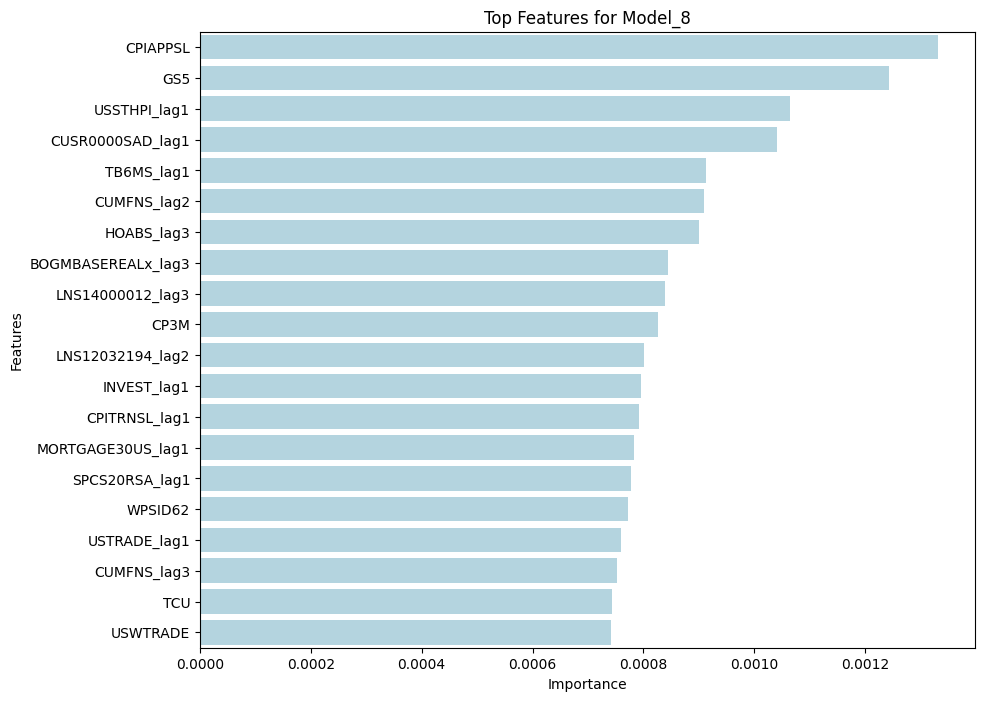

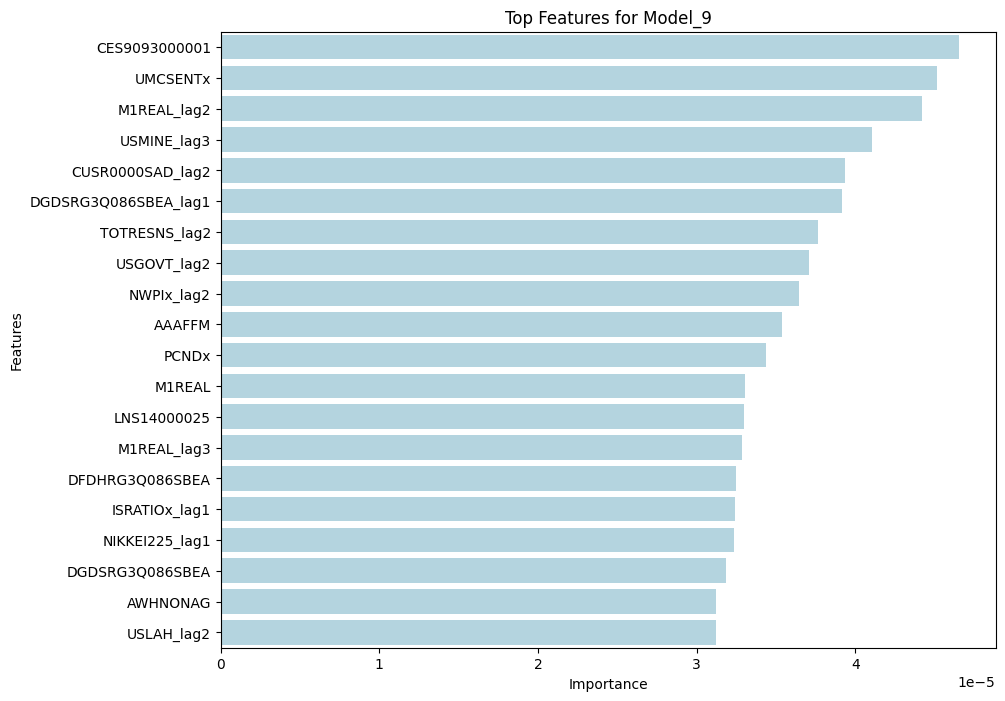

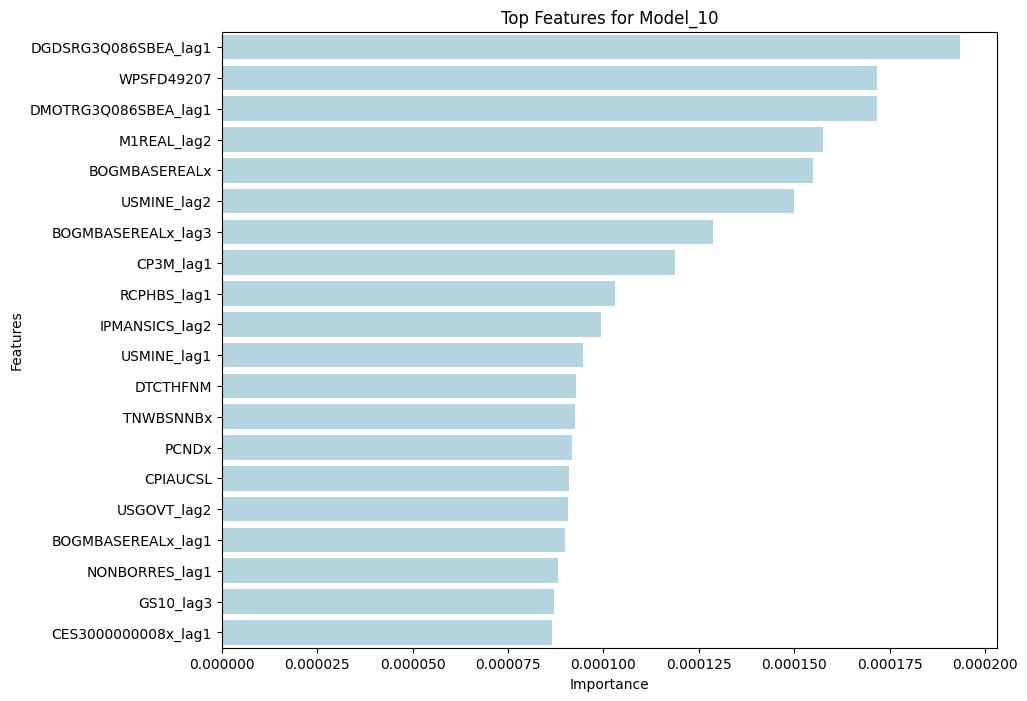

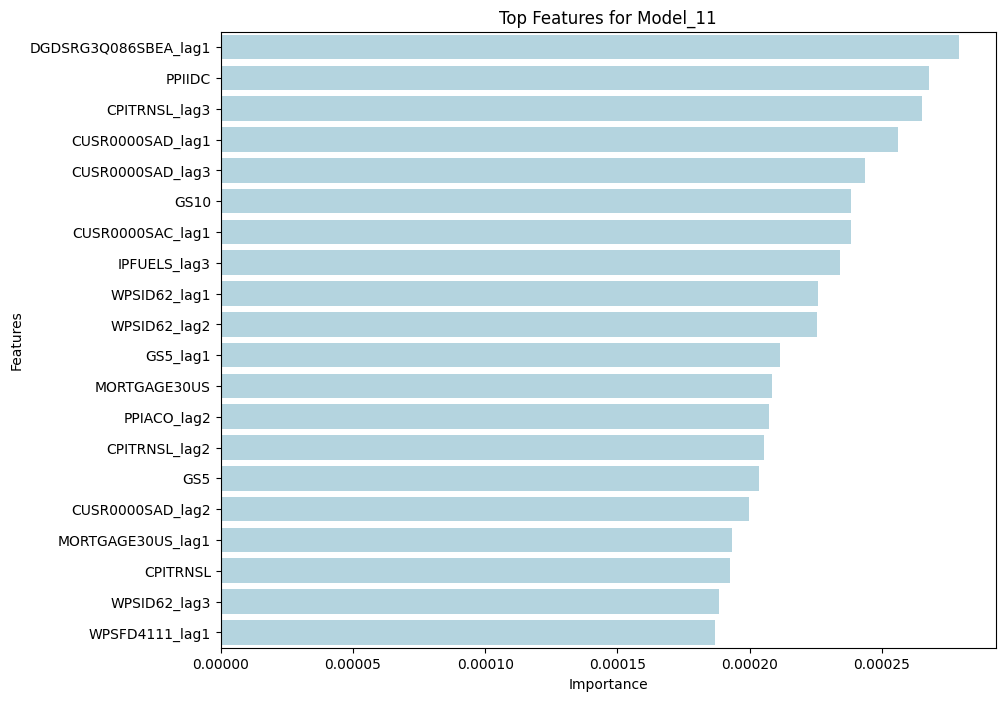

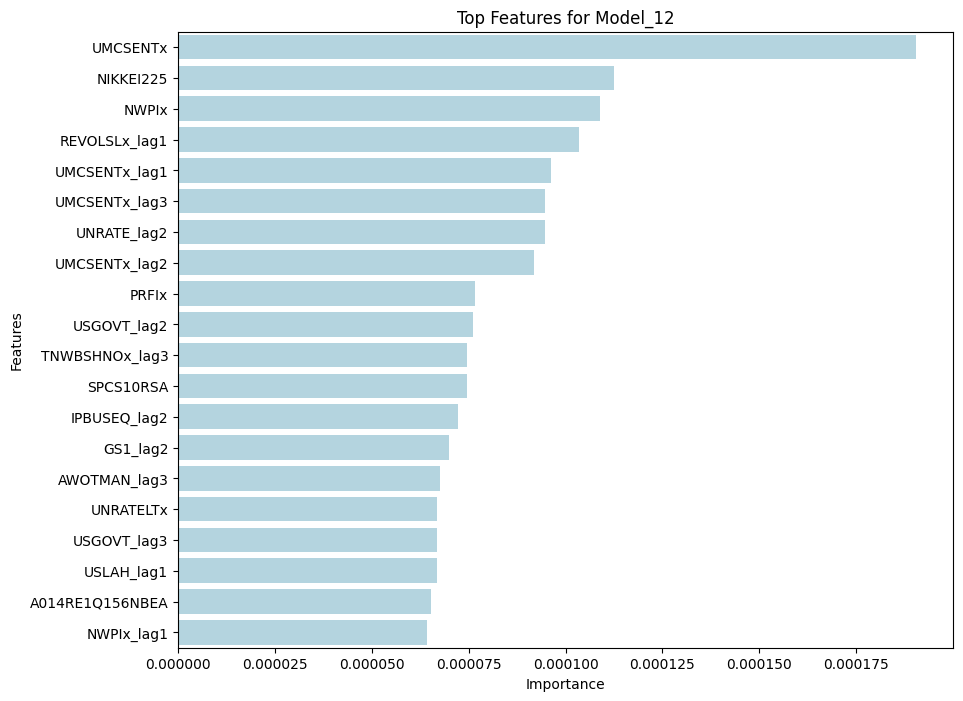

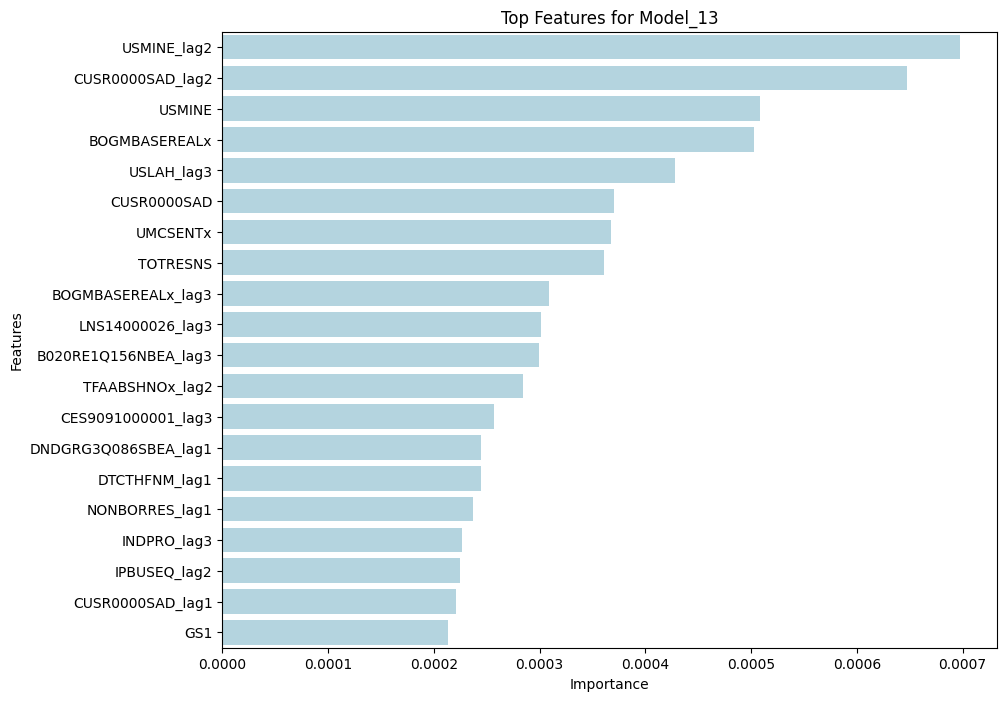

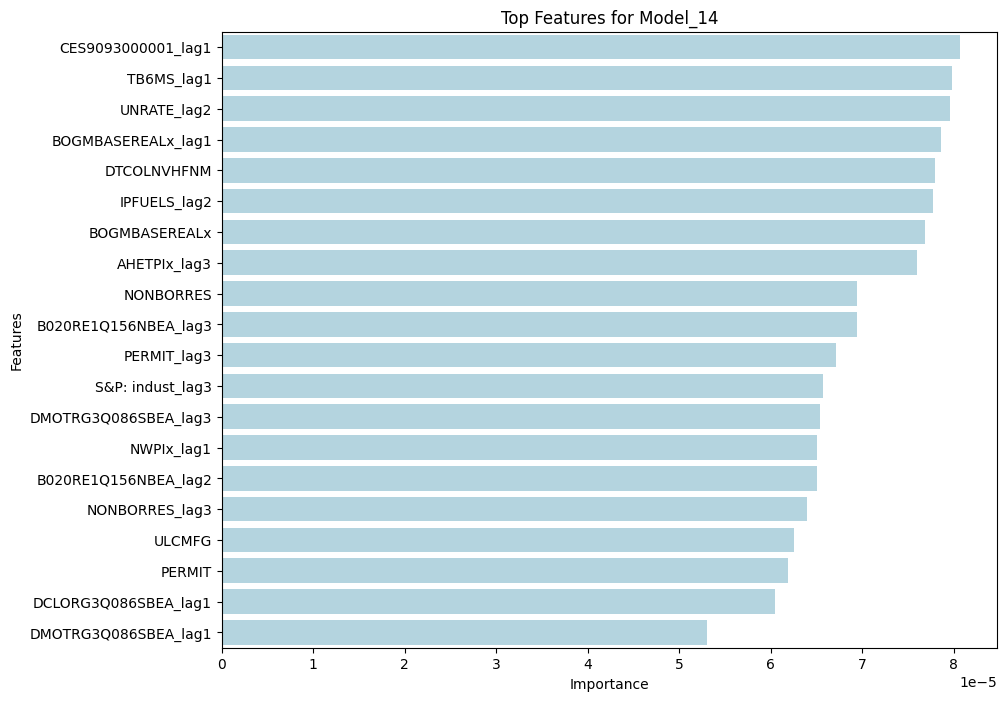

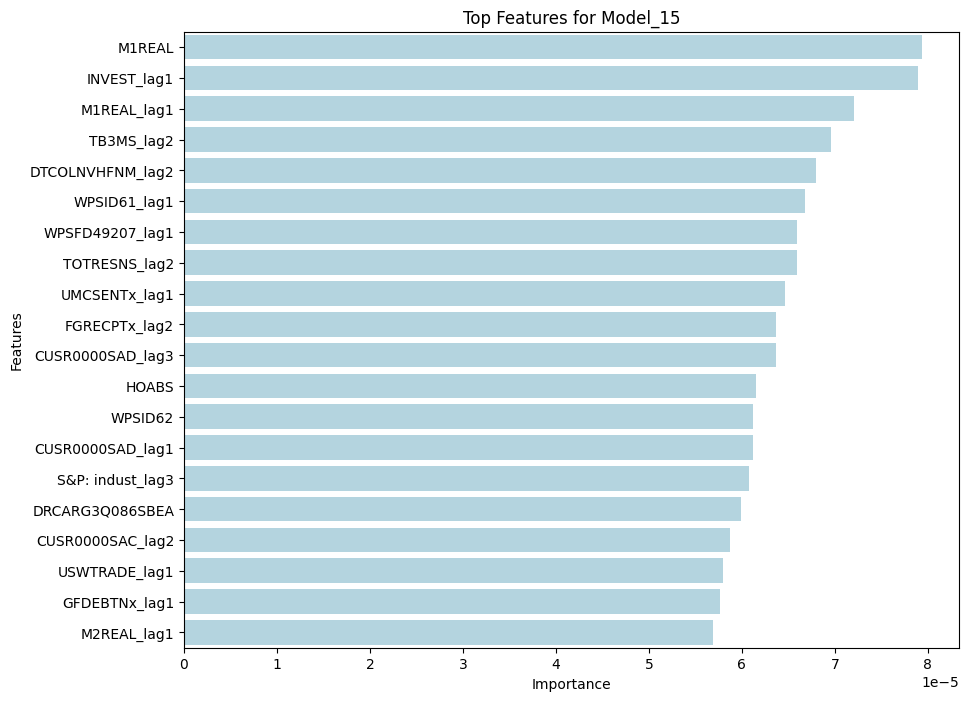

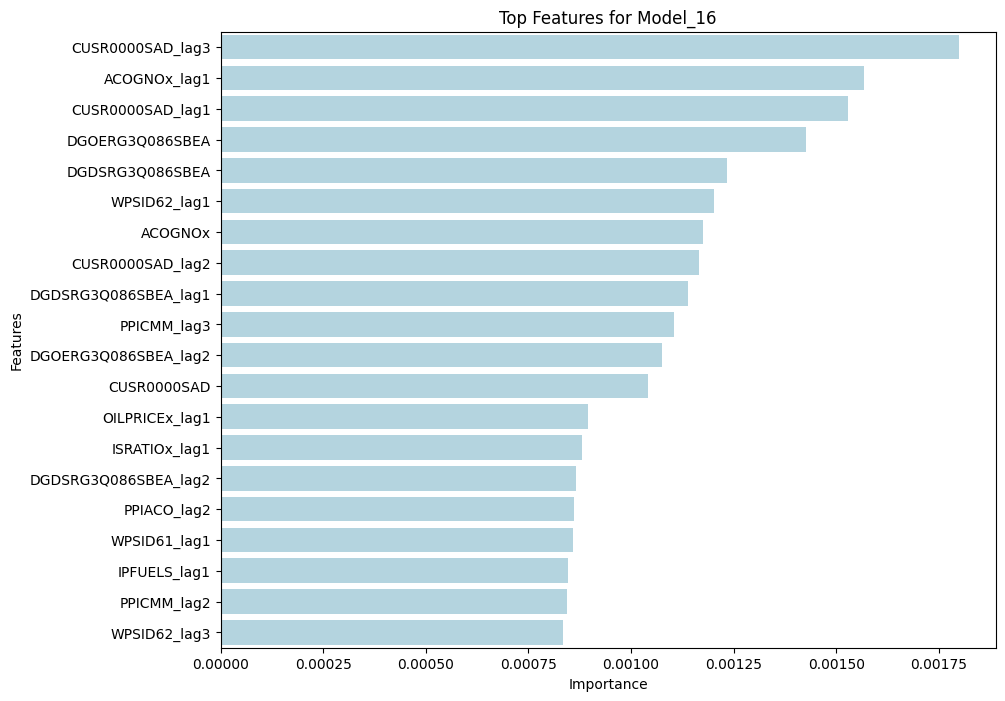

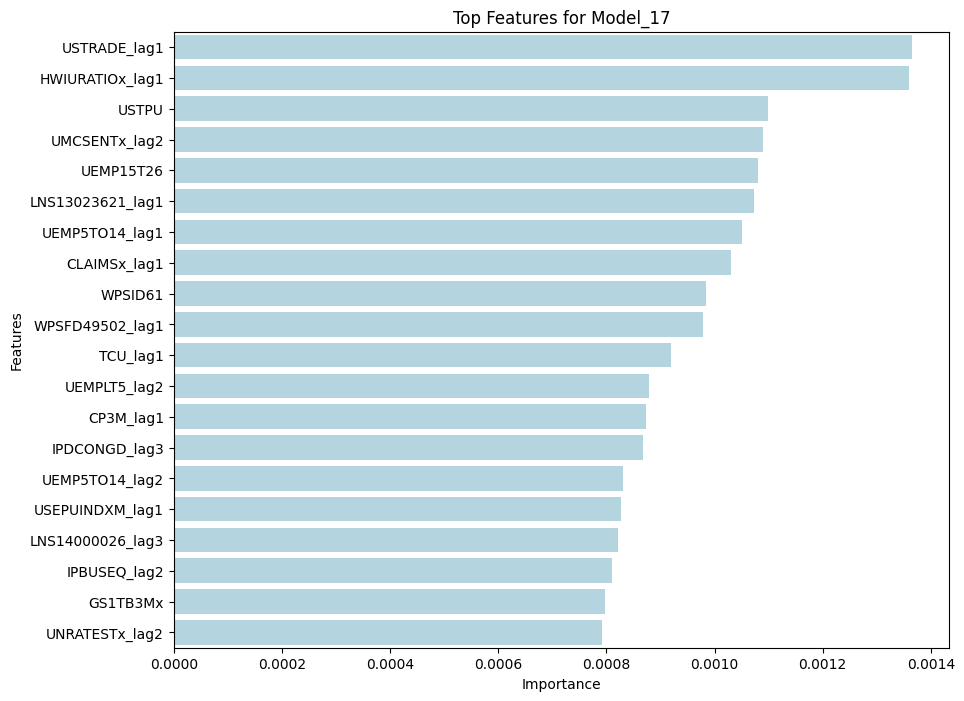

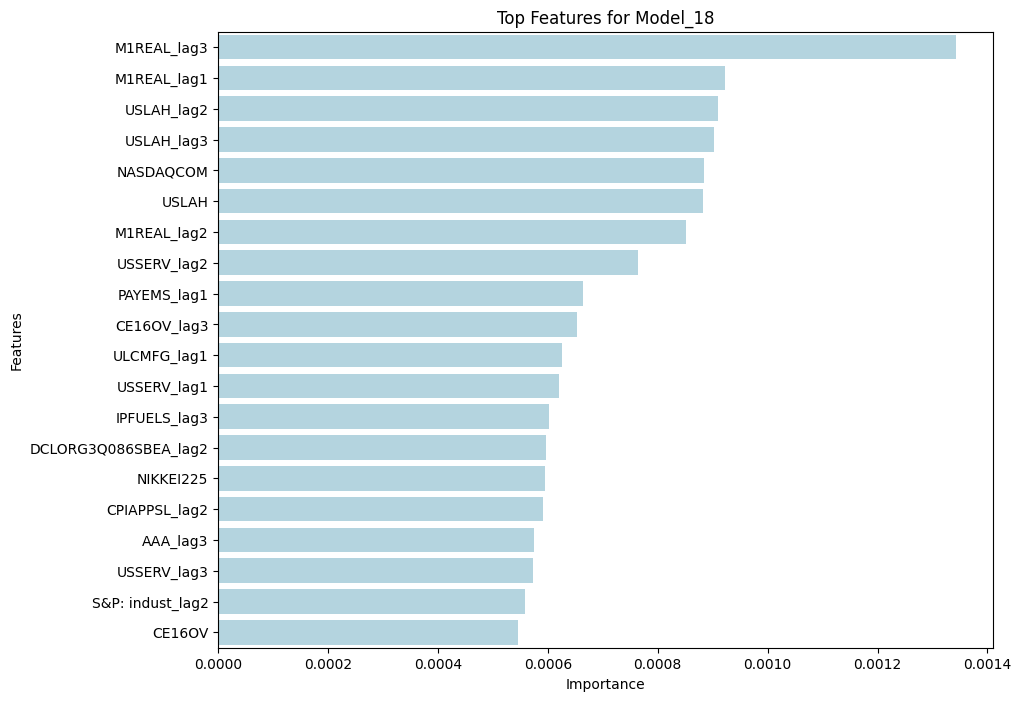

In [ ]:
 # Create the plots
for model, features in top_features_over_time.items():
    top_feature_names = list(features.keys())
    top_importance_values = list(features.values())

    plt.figure(figsize=(10, 8))
    sns.barplot(x=top_importance_values, y=top_feature_names, color='lightblue')
    plt.title(f'Top Features for {model}')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()

In [ ]:
# Select a trained model from the saved_models list
selected_model = saved_models[0]  # For example, taking the first saved model

# Generate predictions using the selected model
y_pred_nn = predict(X_val, selected_model, use_batchnorm)

# Step 2: Train the surrogate model (linear regression)
X_bias = np.c_[np.ones((X_val.shape[1], 1)), X_val.T]
beta = np.linalg.inv(X_bias.T.dot(X_bias)).dot(X_bias.T).dot(y_pred_nn[0])

# Step 3: Interpret the surrogate model
print("Feature Directionality:")
for feature, coef in zip(['Bias'] + original_feature_names, beta):
    print(f"{feature}: {coef}")

# Step 4: Validate the surrogate model (Optional)
y_pred_surrogate = X_bias.dot(beta)
mse = np.mean((y_pred_nn[0] - y_pred_surrogate)**2)
print(f"MSE between neural network and surrogate model: {mse}")

Feature Directionality:
Bias: -154961.5950060273
GDPC1: -694609.9962978598
PCECC96: 4440828.888749517
PCDGx: -840331.252001166
PCESVx: -2174973.6068404675
PCNDx: -746135.2737966538
GPDIC1: 51045.82689627771
FPIx: 69552.77545306977
Y033RC1Q027SBEAx: 18681.886448672227
PNFIx: 31475.24791842677
PRFIx: -1981.0147769353846
A014RE1Q156NBEA: 56614.98434576588
GCEC1: 71118.78637756569
A823RL1Q225SBEA: 23797.45153774906
FGRECPTx: -48403.280064349274
SLCEx: 3711.1570142043615
EXPGSC1: 110603.05557564888
IMPGSC1: -147014.4598050478
DPIC96: -12550.767343799163
OUTNFB: -38677.66677209804
OUTBS: -32166.276981586823
OUTMS: -32970.79188684588
INDPRO: 16769.473670878797
IPFINAL: 17507.74214452593
IPCONGD: -27074.760688799455
IPMAT: 13155.070421934493
IPDMAT: 3203.5881564406463
IPNMAT: -4447.581396821715
IPDCONGD: -1991.6350711922541
IPB51110SQ: 4518.4919195546145
IPNCONGD: 68291.69863654848
IPBUSEQ: -12755.59979782162
IPB51220SQ: -13165.726257656539
TCU: 1426.2881102655865
CUMFNS: 523.527236342117
PAYE